In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import scipy

import sscCdi
sscCdi.__version__

'0.9.2'

In [2]:
DPs0 = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/data.npy')
empty = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/empty.npy')

In [9]:
sscCdi.misc.deploy_visualizer(DPs0,type='abs',title='Measurement',cmap='viridis',axis=0,limits=(0,10000)) # select axis
# sscCdi.misc.deploy_visualizer

In [3]:
# %matplotlib widget
# sscCdi.misc.deploy_visualizer(DPs,type='abs',title='CC',cmap='gray',axis=0) # select axis

In [4]:
z1 = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/z_positions.npy')
z1 = z1[-1]*1e-3
print(z1)
z1 = 0.003705086
z2 = 1 - z1
# z2 = 0.9491

# z1s = np.linspace(z1*0.9,z1*1.1,20)
# z1s
# z2s = np.linspace(z2*0.9,z2*1.1,20)
# z2s

0.004278062


z1=0.003705086, z2=0.996294914, M=269.89926819512425
Object pixel = 5.3353238399999995e-09 m
Probe shape = (2048, 2048)
Deleting 1540 slices
Size of the array: 0.78125 GB
Object shape = (3077, 2990)
FOV = [16.41679146 15.95261828] um2
Data shape = (100, 2048, 2048)
Positions shape = (100, 2)
(100, 2) (100, 2048, 2048) (2048, 2048) (3077, 2990) {'n_cpus': 32, 'energy': 22, 'detector_distance': 0.0036913583377326037, 'detector_pixel_size': 5.3353238399999995e-09, 'source_distance': 0, 'wavelength': 5.6356453357367875e-11, 'object_pixel': 5.3353238399999995e-09, 'object_padding': 100, 'object_shape': (3077, 2990), 'iterations': 10, 'fresnel_regime': True, 'probe_support': None, 'incoherent_modes': 1, 'beta': 0.9, 'epsilon': 0.001}
	Iteration 10/10 	Error: 5.35e-01

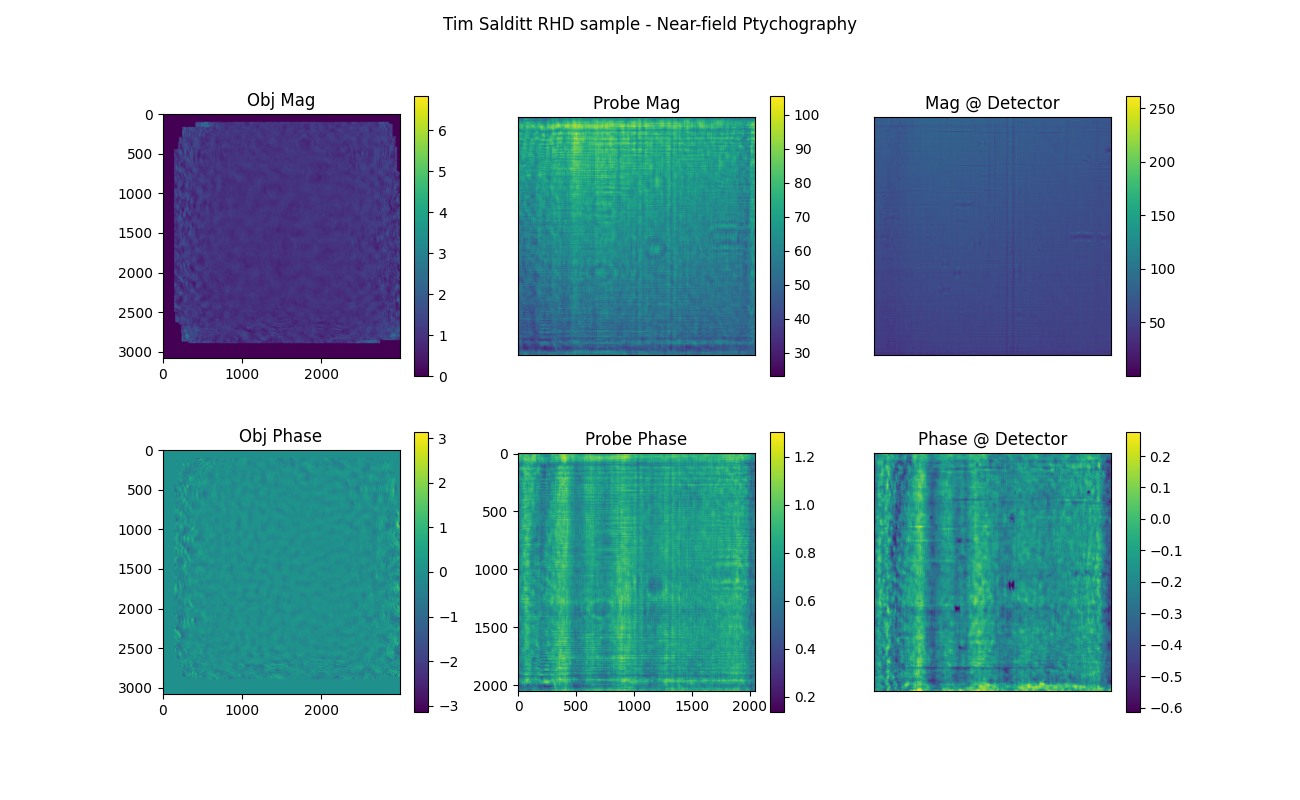

((3077, 2990), (1, 2048, 2048))

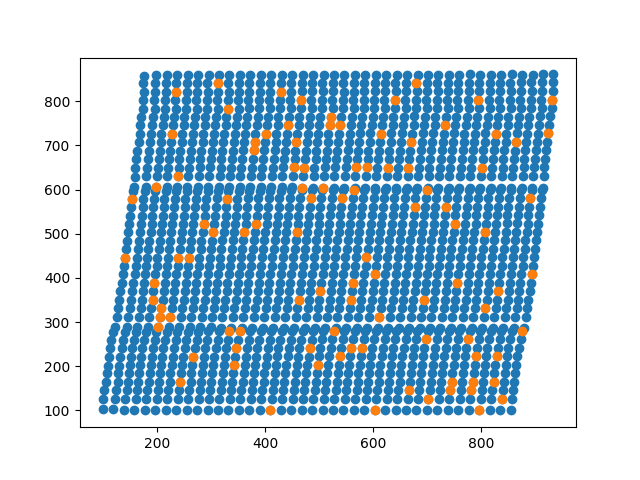

In [5]:
M = (z2+z1)/z1
print(f'z1={z1}, z2={z2}, M={M}')

c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
n_pixels = 2048

inputs = {
"n_cpus": 32, # cpu cores
"energy": 22, #keV
"detector_distance": z2/M, # meter
"detector_pixel_size": 1.44e-6/M,
"source_distance": 0, # should be 0 if parallel beam
}

wavelength = c_speed * planck / inputs["energy"]
inputs["wavelength"] = wavelength

inputs['object_pixel'] = inputs["detector_pixel_size"]
print(f'Object pixel = {inputs["object_pixel"]} m')

positions = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/positions.npy')*1e-3
positions = np.roll(positions,shift=1,axis=1)
DPs0.shape, positions.shape

probe = np.ones_like(empty)
print(f'Probe shape = {probe.shape}')

inputs["object_padding"] = 100
positions = sscCdi.convert_probe_mogno_positions_meters_to_pixels(positions.copy(),inputs["object_pixel"],inputs["object_padding"])

N = 40
fig, ax = plt.subplots()
ax.plot(positions[:,0],positions[:,1],'o')
# ax.plot(positions[0:6,1],positions[0:6,0],'o')
# ax.plot(positions[N:6+N,1],positions[N:N+6,0],'o')

# positions_x = []
# positions_y = []
# for i in range(0,2):
#     A = N*i
#     positions_x.append(positions[A:2+A,1])
#     positions_y.append(positions[A:2+A,0])

# positions_x = np.asarray(positions_x).flatten()
# positions_y = np.asarray(positions_y).flatten()
# ax.plot(positions_x,positions_y,'o')
# positions = np.vstack((np.asarray(positions_y),np.asarray(positions_x))).T

if 1: # remove random points from data
    n_of_points_to_keep = 100
    start_idx = positions.shape[0] - n_of_points_to_keep
    slices_to_ignore = np.random.permutation(positions.shape[0])[-start_idx::]
    print(f'Deleting {slices_to_ignore.shape[0]} slices')
    DPs = np.delete(DPs0,slices_to_ignore,axis=0)
    positions = np.delete(positions,slices_to_ignore,axis=0)

ax.plot(positions[:,0],positions[:,1],'o')

size_in_bytes = DPs.nbytes # Get the size of the array in bytes
size_in_gb = size_in_bytes / (1024**3) # Convert the size to gigabytes
print("Size of the array:", size_in_gb, "GB")

inputs = sscCdi.set_object_shape(inputs, DPs.shape, positions)
# inputs["object_shape"] = (inputs["object_shape"][1],inputs["object_shape"][0])
print(f'Object shape = {inputs["object_shape"]}')
print(f'FOV = {np.asarray(inputs["object_shape"])*inputs["object_pixel"]*1e6} um2')
print(f'Data shape = {DPs.shape}')
print(f'Positions shape = {positions.shape}')

model_object = np.ones(inputs["object_shape"])

probe_guess = np.ones_like(probe) + 1j
probe_guess = probe + 1j
# probe_guess = DPs.mean(0)
obj_guess = np.ones_like(model_object) # constant object

inputs['iterations'] = 10   
inputs["fresnel_regime"] = True
inputs["probe_support"] = None
inputs["incoherent_modes"] = 1
inputs['beta'] = 0.9 # RAAR
inputs['epsilon'] = 0.001 # RAAR; small value to add to probe/object update denominator

print(positions.shape, DPs.shape, probe_guess.shape, obj_guess.shape, inputs)


RAAR_obj, RAAR_probes, _ = sscCdi.ptycho.raar.RAAR_multiprobe_cupy(DPs,positions,obj_guess,probe_guess,inputs)

propagated_probe = sscCdi.fresnel_propagator_cone_beam(RAAR_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],inputs["detector_distance"],inputs["source_distance"]) 


if 1: # plot
    fig, ax = plt.subplots(2,3,figsize=(13,8),dpi=100)
    im1=ax[0,0].imshow(np.abs(RAAR_obj))
    ax[0,0].set_title('Obj Mag')
    # ax[0,0].plot(positions[:,0],positions[:,1],'.',color='gray')
    fig.colorbar(im1, ax=ax[0, 0])

    im2 = ax[1,0].imshow(np.angle(RAAR_obj))
    ax[1,0].set_title('Obj Phase')
    fig.colorbar(im2, ax=ax[1, 0])

    im3 = ax[0,1].imshow(np.abs(RAAR_probes[0]))
    ax[0,1].set_title('Probe Mag')
    fig.colorbar(im3, ax=ax[0, 1])

    im4 = ax[1,1].imshow(np.angle(RAAR_probes[0]))
    ax[1,1].set_title('Probe Phase')
    fig.colorbar(im4, ax=ax[1, 1])

    im5=ax[0,2].imshow(np.abs(propagated_probe))
    ax[0,2].set_title('Mag @ Detector')
    fig.colorbar(im5, ax=ax[0, 2])

    mean = np.mean(np.angle(propagated_probe))
    std=np.std(np.angle(propagated_probe))
    im6 = ax[1,2].imshow(np.angle(propagated_probe),vmin=mean-4*std,vmax=mean+4*std)
    ax[1,2].set_title('Phase @ Detector')
    fig.colorbar(im6, ax=ax[1,2])

    fig.suptitle('Tim Salditt RHD sample - Near-field Ptychography')

    for i, ax in enumerate(ax.ravel()):
        if i==3 or i==0 or i ==4: continue
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

RAAR_obj.shape, RAAR_probes.shape

In [8]:
sscCdi.misc.deploy_visualizer(DPs[0:40],type='abs',title='Measurement',cmap='viridis',axis=0,limits=(0,10000)) # select axis
# sscCdi.misc.deploy_visualizer